**This notebook analyse data from a range of static and dynamic predictors to develop a spatio-temporal analysis of use of outside natural spaces. Using a range of static and dynamic features, a machine learning model is trained to estimate (predict) the number of visitors in outside natural spaces based on people monitoring sites at specific locations**

. People counter data for specific locations (Natural England, North Downs Way, River and Canal Trust)

. Strava Metro (pedestrian) activity data

. Socio-economic and demographic features 

. Open Street Map features

. Rural Urban classification features 

. Living England Habitat Map features

. Accessible Green and Blue infrastructure features

. Historical weather features 

. People and Natural Survey features 



1. <a href='#dest_1'>Import packages</a>

2. <a href='#dest_2'>Config file</a>

3. <a href='#dest_3'>Utility functions</a>

4. <a href='#dest_4'>Load data</a>

5. <a href='#dest_5'>Univariate model: Counter data vs Strava data</a>

6. <a href='#dest_6'>Static and dynamic features merging</a>

7. <a href='#dest_7'>Multivariate Regression model</a> 


https://github.com/pycaret/pycaret/blob/master/examples/Pycaret_2.1_Regression_EmployeePerformance.ipynb

In [1]:
os.chdir('..')

**Import Packages**
<a id='dest_1'></a>

In [2]:
%reload_ext autoreload
%autoreload 2

from model_packages import *

/Users/jamieelliott/.pyenv/versions/3.10.9/envs/req_old/bin/python
Confirm Pycaret version is ?
Pycaret Version:  3.0.2


**Config file:**
<a id='dest_2'></a>

In [3]:
from model_config import *

**Utility functions**
<a id='dest_3'></a>

In [4]:
from model_utils import *

# LOAD  DATASETS

<a id='dest_4'></a>

## 1. Read Census 2011 data- Socio-economic and demographic features

This is an Open dataset from https://www.nomisweb.co.uk

The dataset has been prepared in a separate notebook (Census features)

In [5]:
df_demg=pd.read_pickle(census_locn_file)
# Area of each buffer region around the counter sites.
# Buffer zone is 5km radius around each site:pi*r^2: 78.5 sq km
area_sites_oa=df_demg.groupby('counter')['area_sq_km'].sum().reset_index()


df_demg['Density (number of persons per sq_km)']=100*df_demg['Density (number of persons per hectare)']

## 2. People monitoring counter data

**Target variable in the model (y)**

In [6]:
# Location of the counter sites

#Natural england sites
counter_ne=assgn_lat_lon(ne_countr_locn_file,'counter')

#North Downs way sites
counter_nd=assgn_lat_lon(ndw_countr_locn_file,'counter')


# 01-2023- No training data available for these sites-
# Canal River Trust sites
counter_cr=assgn_lat_lon(crt_countr_locn_file,'Counter')\
[['Counter','latitude','longitude','geometry']]
counter_cr.rename(columns={'Counter':'counter'},inplace=True)
all_counter_location=pd.concat([counter_ne,counter_nd,counter_cr]).reset_index(drop=True)

(35, 25)
(35, 23)
Null values 0


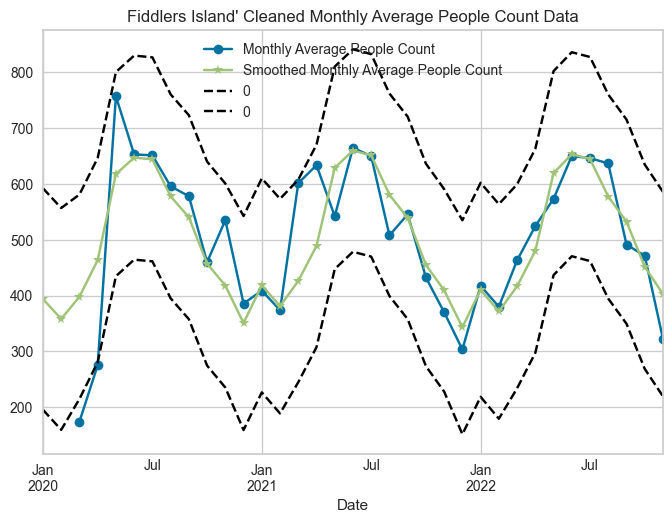

In [7]:
#*Pre-processing of counter data- Target variable*

df_count_ne=prepare_counter_data(ne_strava_data_file,2020)

(15, 12)
(15, 12)
Null values 0


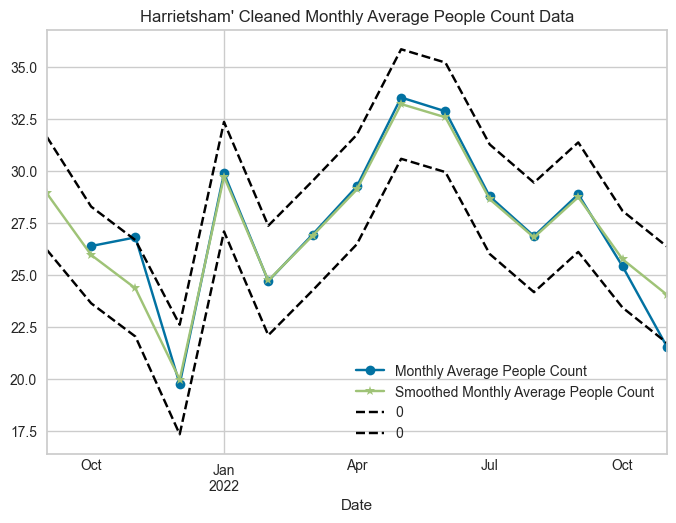

In [8]:
# North Downs Way data prep
df_count_nd=prepare_counter_data(ndw_strava_data_file,2021)

In [9]:
#Visualisation of the time series data

df_count_line=df_count_ne.copy().sort_index().reset_index()

fig = px.line(df_count_line, x='Date', y=df_count_line.columns,
              hover_data={"Date": "|%B %d, %Y"},
              markers=True, title='Monthly Average People Count for each site')
fig.update_xaxes(dtick="M3",tickformat="%b\n%Y")
fig.update_layout(
    legend_title='Site',
     yaxis_title='Monthly Average People Count'
)

fig.show()

pathlib.Path(f"./outputs/").mkdir(parents=True, exist_ok=True)
fig.write_image("./outputs/people_count_plotly.png",scale=6, width=900, height=550)


In [10]:
df_count_line_val=df_count_nd.copy().sort_index().reset_index()

fig = px.bar(df_count_line_val, x='Date', y=df_count_line_val.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='People counter')
fig.update_xaxes(dtick="M1",tickformat="%b\n%Y")
fig.show()

In [11]:
all_df_count_line= pd.concat([df_count_ne, df_count_nd]).reset_index().melt('Date', var_name='Site', value_name='MAPC')
fig = px.line(all_df_count_line.groupby("Date").mean().reset_index(), x='Date', y='MAPC',
              hover_data={"Date": "|%B %d, %Y"},
              title='Mean of Monthly Average People Count Across all sites',markers=True)
fig.update_xaxes(dtick="M3",tickformat="%b\n%Y")
fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)
# fig.update_layout(plot_bgcolor='white')



fig.show()

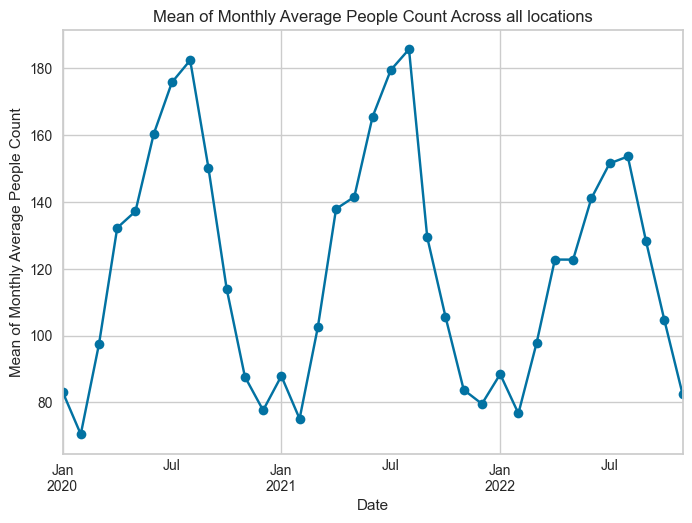

In [12]:
fig,ax = plt.subplots()
all_df_count_line.groupby("Date").mean().reset_index().plot(ax=ax, style=['-o'], y='MAPC', x='Date', label='_0')
plt.title('Mean of Monthly Average People Count Across all locations')
plt.ylabel('Mean of Monthly Average People Count')

fig.savefig(f"./outputs/mean_MAPC_all.png", format= 'png', dpi=300, bbox_inches='tight')

## 3. Open Street Map data

We obtain points of interest around the counter locations using openstreet map

The following takes a long time to process so we have saved the data locally for future use

In [13]:
# check for data saved locally and create if doesnt exist, repeated for each counter data set

if os.path.isfile(data_folder+'ne_pois_df.pkl') == True:
    print("File already exists")
    ne_pois_df= pd.read_pickle(data_folder+'ne_pois_df.pkl')
else: 
    ne_pois_df=get_pois(ne_countr_locn_file,'ne')


if os.path.isfile(data_folder+'dw_pois_df.pkl') == True:
    print("File already exists")
    nd_pois_df= pd.read_pickle(data_folder+'dw_pois_df.pkl')
else: 
    nd_pois_df=get_pois(ndw_countr_locn_file,'dw')


if os.path.isfile(data_folder+'rvr_cnl_pois_df.pkl') == True:
    print("File already exists")
    cr_pois_df= pd.read_pickle(data_folder+'rvr_cnl_pois_df.pkl')
else: 
    cr_pois_df=get_pois(crt_countr_locn_file,'rvr_cnl')

File already exists
File already exists
File already exists


In [14]:
# All pois across all sites
df_pois_all_sites=pd.concat([ne_pois_df,nd_pois_df,cr_pois_df]).dropna(axis=1).reset_index(drop=True)

# Merge it with buffer zone areas for each site
df_pois_all_sites=df_pois_all_sites.merge(area_sites_oa.rename(columns={'counter':'site'}),on=['site'],how='inner')


num_cols=[x for x in df_pois_all_sites.columns if x not in ['area_sq_km','site']]

# Density of pois--CJ: Is this better than raw numbers ?
df_pois_all_sites[num_cols]=df_pois_all_sites[num_cols].div(df_pois_all_sites['area_sq_km'],axis=0)

del df_pois_all_sites['area_sq_km']

df_pois_all_sites.to_pickle(data_folder+'pois_data_all_sites.pkl')

## Socioeconomic and Demographic Data Augmentation

Socioeconomic and demographic features taken from the census have spatial correlations and we need to infer the correlated features (using Factor Analysis)

### Define collecive features

In [15]:
# Define collective features

df_demg['3+ people in household']=df_demg[['3 people in household','4 people in household',\
                                           '5 people in household','6 people in household',\
                                           '7 people in household','8 or more people in household']].sum(axis=1)


df_demg['1-2 people in household']=df_demg[['1 person in household','2 people in household']].sum(axis=1)



household_occupancy_ftrs=['1-2 people in household','3+ people in household']




df_demg['Age group 0-25']=df_demg[['Age 0 to 4','Age 5 to 7','Age 8 to 9', 'Age 10 to 14',\
                                   'Age 15', 'Age 16 to 17','Age 18 to 19', 'Age 20 to 24']].sum(axis=1)

df_demg['Age group 25-65']=df_demg[['Age 25 to 29', 'Age 30 to 44','Age 45 to 59', 'Age 60 to 64']].sum(axis=1)


df_demg['Age group 65+']=df_demg[['Age 65 to 74', 'Age 75 to 84','Age 85 to 89', 'Age 90 and over']].sum(axis=1)



age_ftrs=['Age group 0-25','Age group 25-65','Age group 65+']



df_demg['Household is deprived in at least 1 dimension']=df_demg[['Household is deprived in 1 dimension',\
                                                                  'Household is deprived in 2 dimensions',\
                                                                  'Household is deprived in 3 dimensions',\
                                                                  'Household is deprived in 4 dimensions']].\
sum(axis=1)



deprivation_ftrs=['Household is not deprived in any dimension','Household is deprived in at least 1 dimension']

people_density_ftrs=['Density (number of persons per sq_km)']



df_demg['Unemployed_population']=df_demg[['Unemployed: Age 16 to 24','Unemployed: Age 50 to 74',\
                                          'Unemployed: Never worked','Long-term unemployed']].sum(axis=1)

econominc_activity_ftrs=['Economically active', 'Economically Inactive','Unemployed_population']


df_demg['Population in Good Health']=df_demg[['Very good health','Good health','Fair health']].sum(axis=1)


df_demg['Population in Bad Health']=df_demg[['Bad health', 'Very bad health']].sum(axis=1)


health_ftrs=['Population in Good Health','Population in Bad Health']

df_demg['Mixed/Black/others']=df_demg[['Mixed/multiple ethnic groups',\
                                       'Black/African/Caribbean/Black British',\
                                       'Other ethnic group']].sum(axis=1)




ethnic_ftrs=['White','Asian/Asian British','Mixed/Black/others']




       
        
df_demg['2 or more cars or vans in household']=df_demg[['2 cars or vans in household',\
                                                        '3 cars or vans in household',\
                                                        '4 or more cars or vans in household']].sum(axis=1)

vehicle_ftrs=['No cars or vans in household', '1 car or van in household',\
                  '2 or more cars or vans in household']



all_ftrs_sbset=[household_occupancy_ftrs,age_ftrs,deprivation_ftrs,econominc_activity_ftrs,health_ftrs,ethnic_ftrs,\
                vehicle_ftrs]

# Get proportion of all Census features
for cols in all_ftrs_sbset:
    
    df_demg[cols]=get_proportion(df_demg,cols)
    
    

df_demg=df_demg[[item for sublist in all_ftrs_sbset for item in sublist]+\
                people_density_ftrs+['counter']+['geometry','urban_rural']+['2011 output area']].copy()

### Split the demographic data for counter sites Natural England vs North Downs Way vs River Canal Trust and compute average values of Census variables for each counter sites

In [16]:
df_demg_ne=df_demg[df_demg['counter'].isin(list(counter_ne['counter'].values))].reset_index(drop=True)


df_demg_nd=df_demg[df_demg['counter'].isin(list(counter_nd['counter'].values))].reset_index(drop=True)


df_demg_cr=df_demg[df_demg['counter'].isin(list(counter_cr['counter'].values))].reset_index(drop=True)

### Define baseline population for regression

In [17]:
# All Socio-economic demographic features

ftrs_to_keep_pop=[item for sublist in all_ftrs_sbset for item in sublist]+people_density_ftrs



# For regression analysis we need to define baseline population- 
# against which the regr coefs can be compared

baseline_pop=['1-2 people in household', 'Age group 65+', 'Household is not deprived in any dimension',\
'Economically Inactive' ,'Population in Good Health', 'White', '1 car or van in household'] 


ftrs_to_keep_pop=[x for x in ftrs_to_keep_pop if x not in baseline_pop]

### Compile demographic features from non-baseline population

In [18]:
# Average proportion of Census variables for all counter sites excluding baseline population


# Natural England Counters
df_demg_ne[ftrs_to_keep_pop]=df_demg_ne[ftrs_to_keep_pop].astype(float)

df_demg_ne=df_demg_ne.groupby('counter')[ftrs_to_keep_pop].mean().reset_index()

# Merge it with buffer zone areas for each site
df_demg_ne=df_demg_ne.merge(area_sites_oa,on=['counter'],how='inner')

# normalise the census features same units as pois

num_cols=[x for x in ftrs_to_keep_pop if x not in people_density_ftrs]

#df_demg_ne[num_cols]=df_demg_ne[num_cols].div(df_demg_ne['area_sq_km'],axis=0)

del df_demg_ne['area_sq_km']


# North Downs Way Counters
df_demg_nd[ftrs_to_keep_pop]=df_demg_nd[ftrs_to_keep_pop].astype(float)

df_demg_nd=df_demg_nd.groupby('counter')[ftrs_to_keep_pop].mean().reset_index()

# Merge it with buffer zone areas for each site
df_demg_nd=df_demg_nd.merge(area_sites_oa,on=['counter'],how='inner')

# normalise the census features same units as pois

#df_demg_nd[num_cols]=df_demg_nd[num_cols].div(df_demg_nd['area_sq_km'],axis=0)

del df_demg_nd['area_sq_km']


# CRT Counters
df_demg_cr[ftrs_to_keep_pop]=df_demg_cr[ftrs_to_keep_pop].astype(float)

df_demg_cr=df_demg_cr.groupby('counter')[ftrs_to_keep_pop].mean().reset_index()

# Merge it with buffer zone areas for each site
df_demg_cr=df_demg_cr.merge(area_sites_oa,on=['counter'],how='inner')

# normalise the census features same units as pois

#df_demg_cr[num_cols]=df_demg_cr[num_cols].div(df_demg_cr['area_sq_km'],axis=0)

del df_demg_cr['area_sq_km']


all_sites_demographic=pd.concat([df_demg_ne[ftrs_to_keep_pop],df_demg_nd[ftrs_to_keep_pop],\
                                 df_demg_cr[ftrs_to_keep_pop]]).reset_index(drop=True)

### Factor Analysis on Census Features

In [19]:
# Create factor analysis object and perform factor analysis

df_chsen=all_sites_demographic
fa = FactorAnalyzer()
fa.fit(df_chsen)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()

#Number of factors is equal to those with eigen values > 1
numb_fctr=sum(i > 1 for i in list(ev))

# re-run factor analysis with only factors whos eigenvector was > 1 in initial run 
fa = FactorAnalyzer(n_factors=numb_fctr)
fa.fit(df_chsen)


df_load=pd.DataFrame(fa.loadings_,columns=['Factor_'+str(x+1) for x in range(numb_fctr)]).\
set_index(df_chsen.columns)

print(df_load[abs(df_load)>0.5].fillna('--'))


print(fa.get_communalities())


# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance
print(fa.get_factor_variance())

                                               Factor_1  Factor_2  Factor_3
3+ people in household                               --        --  1.150827
Age group 0-25                                       --        --   0.64552
Age group 25-65                                0.764134 -0.668368        --
Household is deprived in at least 1 dimension        --   0.75312        --
Economically active                                  -- -1.026174        --
Unemployed_population                                --  0.608985        --
Population in Bad Health                             --  0.920221        --
Asian/Asian British                                  --        --  0.751917
Mixed/Black/others                             0.726011        --        --
No cars or vans in household                   0.936226        --        --
2 or more cars or vans in household           -0.805307        --        --
Density (number of persons per sq_km)          1.043687        --        --
[1.44968176 

#### Inferring factor loadings

Spatial correlations amongst areas with high:
1. Proportion of deprived households, unemployed population,
   proportion of population in bad health,
2. Proportion of larger households, younger age population, Asian demographics
3. Proportion of more densely populated areas, no cars or vans, with higher proportion of population Black/Mixed ethnic background,


In [20]:
demographic_dat_all_sites=pd.concat([df_demg_ne[ftrs_to_keep_pop+['counter']],\
                                    df_demg_nd[ftrs_to_keep_pop+['counter']],\
                                    df_demg_cr[ftrs_to_keep_pop+['counter']]]).reset_index(drop=True)


demographic_dat_all_sites.to_pickle(data_folder+'socio_economic_data_all_sites.pkl')

### Using Variance Inflation Factor to identify possible correlations between demographic and Points Of Interest features

#The Variance Inflation Factor (VIF) is a measure of colinearity 
#among predictor variables within a multiple regression. It is 
#calculated by taking the the ratio of the variance of all a given model's
#betas divide by the variane of a single beta if it were fit alone.

https://quantifyinghealth.com/vif-threshold/

     VIF Factor                                       features
0     69.190633                                    amenity_bar
1    306.279247                                   amenity_cafe
2     22.675500                                amenity_parking
3    651.534886                             amenity_restaurant
4     53.982165                                amenity_toilets
5      2.439106                              tourism_camp_site
6      3.670679                            tourism_guest_house
7     98.448302                                  tourism_hotel
8      4.035312                            tourism_picnic_site
9     28.136719                               highway_bus_stop
10     1.650411                             tourism_attraction
11     2.526745                                    amenity_pub
12     2.160633                            amenity_beer_garden
13     8.072386                            amenity_bus_station
14     5.711898                             amenity_foo

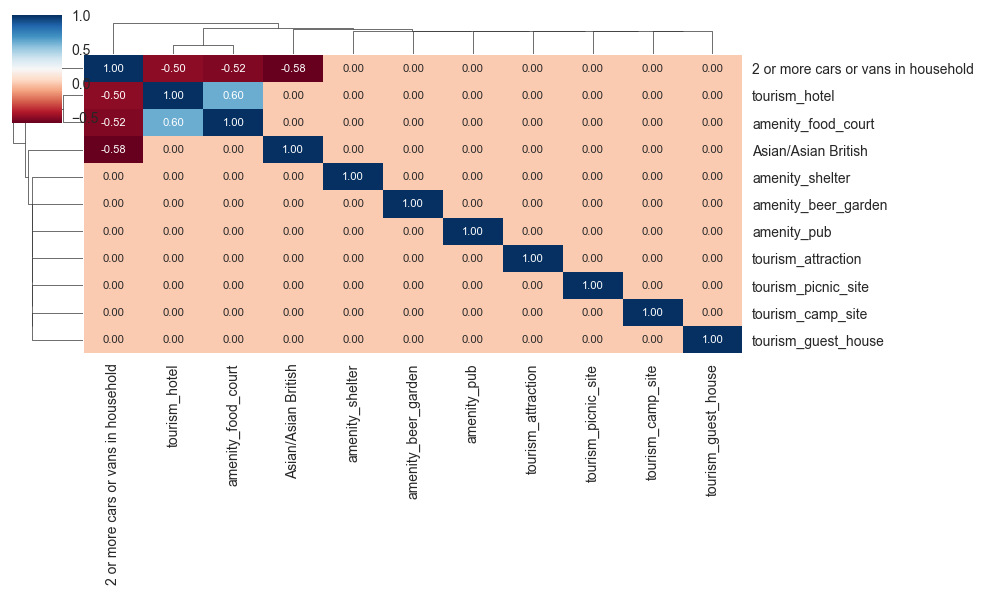

In [21]:
# merge demographic and POI features
df_pois_demo_all_sites=df_pois_all_sites.merge(demographic_dat_all_sites,left_on=['site'],\
                                               right_on=['counter'],how='inner')

df_pois_demo_all_sites=df_pois_demo_all_sites._get_numeric_data()

df_chsen=df_pois_demo_all_sites

# For each ftr, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_chsen.values, i) for \
                     i in range(df_chsen.shape[1])]
vif["features"] = df_chsen.columns
print(vif)

print('+'*100)

#select only features with VIF score <= 2.5

df_cens_remv_multi_coll=calculate_vif_(df_chsen._get_numeric_data(),\
                                       thresh=2.5)[0]

# For each ftr, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_cens_remv_multi_coll.values, i) for \
                     i in range(df_cens_remv_multi_coll.shape[1])]
vif["features"] = df_cens_remv_multi_coll.columns
print(vif)

# select only low VIF score features
low_vif_ftrs_cens=list(vif.features.values)


# Joint Census ftrs and POIS
sel_demo_pois_vrbls=low_vif_ftrs_cens

# correlation matrix of varibales with low VIF Score
get_corr_matrx(df_chsen[low_vif_ftrs_cens],0.5)

## People Counter Data

**Filter counter data for a subset of monitoring sites (where data quality is good enough based on preprocessing of counter data)**

In [22]:
# counter sites for which we have the people counter data (after pre-processing)

# Natural England
places_ne=[x.replace("  "," ").replace(" ","_") for x in df_count_ne.columns if x not in ['Date', 'Month']]
# Only get coordinates for those sites
counter_ne=counter_ne[counter_ne['counter'].isin(places_ne)].reset_index(drop=True)
counter_ne['coordinates'] = list(zip(counter_ne.latitude, counter_ne.longitude))
site_names_ne=list(counter_ne['counter'])
# save sites with good data quality
counter_ne.to_pickle(data_folder+'counter_ne.pkl')


# North Downs Way
places_nd=[x.replace("  "," ").replace(" ","_") for x in df_count_nd.columns if x not in ['Date', 'Month']]
# Only get coordinates for those sites
counter_nd=counter_nd[counter_nd['counter'].isin(places_nd)].reset_index(drop=True)
counter_nd['coordinates'] = list(zip(counter_nd.latitude, counter_nd.longitude))
site_names_nd=list(counter_nd['counter'])
# save sites with good data quality
counter_nd.to_pickle(data_folder+'counter_nd.pkl')


# River and Canal Trust: No counter data available yet (17-02-2023)
counter_cr.to_pickle(data_folder+'counter_cr.pkl')
places_cr=df_demg_cr['counter'].unique().tolist()
site_names_cr=places_cr

## STRAVA Metro data

In [23]:
# The following steps are required to clean up the name of folders obtained from Strava

file_names_ne=[x[0] for x in os.walk(strava_data_loc) if '_ped' in x[0]]

for x in file_names_ne:
    os.rename(x,x.replace('_1_edge_daily_2020-01-01-2022-11-30_ped',""))
    
    
file_names_nd=[x[0] for x in os.walk(val_strava_data_loc) if '_ped' in x[0]]

for x in file_names_nd:
    os.rename(x,x.replace('_1_edge_daily_2020-01-01-2022-11-30_ped',""))
    
    
file_names_nd=[x[0] for x in os.walk(canal_trust_strava_data_loc) if '_ped' in x[0]]

for x in file_names_nd:
    os.rename(x,x.replace('_1_edge_daily_2020-01-01-2022-11-30_ped',""))

In [24]:
# Obtain Strava data

strava_count_ne=prepare_strava(site_names_ne,strava_data_loc) 

strava_count_nd=prepare_strava(site_names_nd,val_strava_data_loc)

strava_count_cr=prepare_strava(site_names_cr,canal_trust_strava_data_loc)

In [25]:
strava_count_ne

,Date,total_trip_count,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,...,reverse_18_34_people_count,forward_35_54_people_count,reverse_35_54_people_count,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed,site
0,2020-01,10.800000,5.200000,5.600000,5.000000,5.400000,0.000000,0.000000,5.200000,5.200000,...,1.000000,0.800000,2.000000,0.400000,0.400000,0.0,0.000000,0.923600,1.042400,Banks_Lane
1,2020-02,8.809524,5.476190,3.571429,5.476190,3.571429,0.000000,0.000000,5.238095,3.571429,...,0.238095,2.142857,1.666667,0.000000,0.000000,0.0,0.000000,0.871429,0.910952,Banks_Lane
2,2020-03,9.800000,5.000000,5.000000,5.000000,5.000000,0.000000,0.200000,4.800000,4.800000,...,1.200000,1.600000,2.000000,0.400000,0.200000,0.0,0.000000,0.842400,1.248000,Banks_Lane
3,2020-04,11.896552,6.034483,5.689655,6.034483,5.689655,0.000000,0.000000,6.034483,5.689655,...,1.206897,2.758621,3.103448,0.172414,0.172414,0.0,0.000000,0.994483,1.891724,Banks_Lane
4,2020-05,12.666667,6.666667,6.500000,6.666667,6.500000,0.000000,0.000000,6.500000,6.500000,...,1.833333,2.500000,2.333333,0.166667,0.333333,0.0,0.166667,1.074333,1.280333,Banks_Lane
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,2022-07,12.931034,8.103448,4.655172,7.931034,4.310345,3.448276,2.413793,3.965517,1.551724,...,0.344828,2.931034,1.551724,1.551724,0.517241,0.0,0.000000,0.858966,0.432414,Walltown_Quarry
680,2022-08,11.129032,7.096774,4.354839,7.096774,4.193548,2.741935,2.096774,4.032258,1.774194,...,0.483871,2.580645,1.774194,0.806452,0.806452,0.0,0.161290,0.990323,0.644194,Walltown_Quarry
681,2022-09,11.851852,6.666667,5.000000,6.666667,5.000000,4.259259,2.592593,2.222222,1.481481,...,0.370370,2.777778,1.111111,0.740741,0.740741,0.0,0.370370,0.857407,0.654815,Walltown_Quarry
682,2022-10,7.105263,5.526316,2.105263,5.526316,2.105263,1.578947,0.526316,2.894737,1.052632,...,0.000000,2.894737,0.263158,0.000000,0.263158,0.0,0.000000,0.722105,0.224211,Walltown_Quarry


### Processing of counter data and reshaping the data to merge with the Strava Metro data

In [26]:
# Natural England

# data wrangling
df_count_ne_strava=df_count_ne.copy()
df_count_ne_strava.columns=[x.replace("  "," ").replace(" ","_") for x in df_count_ne_strava.columns]
df_count_ne_strava=df_count_ne_strava.stack().reset_index()
df_count_ne_strava.columns = ['Date', 'site', 'people_counter_data']
df_count_ne_strava['Date']=df_count_ne_strava['Date'].dt.to_period('M').astype("string")

print('+'*200)

# merge people counter and strava data 
df_count_ne_strava=df_count_ne_strava.merge(strava_count_ne,how='inner',left_on=['Date','site'],\
                                            right_on=['Date','site'])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [27]:
df_count_ne_strava

,Date,site,people_counter_data,total_trip_count,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,...,forward_18_34_people_count,reverse_18_34_people_count,forward_35_54_people_count,reverse_35_54_people_count,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed
0,2020-01,Banks_Lane,96.982653,10.800000,5.200000,5.600000,5.000000,5.400000,0.000000,0.000000,...,1.200000,1.000000,0.800000,2.000000,0.400000,0.400000,0.000000,0.0,0.923600,1.042400
1,2020-01,Blue_Anchor_Bay,2.266945,5.000000,5.000000,0.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.840000,0.000000
2,2020-01,Clevedon,12.057368,12.333333,5.833333,6.333333,5.833333,6.333333,0.000000,0.000000,...,0.666667,0.666667,3.333333,2.666667,0.666667,1.000000,0.000000,0.0,1.216000,1.171000
3,2020-01,Crickley_Hill_Country_Park,56.105233,11.000000,5.000000,7.000000,5.000000,7.000000,0.000000,3.000000,...,0.500000,0.500000,3.500000,3.500000,0.000000,0.500000,0.000000,0.0,1.195000,0.506000
4,2020-01,Fiddlers_Island,393.832764,16.521739,8.478261,8.913043,8.260870,8.913043,0.217391,0.217391,...,3.260870,4.130435,2.826087,3.043478,0.000000,0.217391,0.000000,0.0,2.010870,1.878261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,2022-11,Sandwich_Peninsula,20.865160,5.000000,1.666667,3.333333,1.666667,3.333333,0.000000,0.000000,...,0.000000,0.000000,1.666667,1.666667,0.000000,0.000000,0.000000,0.0,0.000000,0.956667
680,2022-11,Sennen_Cove,138.169441,9.117647,3.235294,5.882353,3.235294,5.294118,0.294118,1.176471,...,0.588235,1.470588,0.882353,3.235294,0.294118,0.000000,0.294118,0.0,0.351176,0.884118
681,2022-11,Strete_Gate,53.261960,6.666667,3.333333,3.333333,3.333333,3.333333,0.000000,0.000000,...,0.000000,0.000000,1.666667,1.666667,0.000000,0.000000,0.000000,0.0,1.063333,0.420000
682,2022-11,Vessey_Pastures,15.190498,25.000000,25.000000,0.000000,23.750000,0.000000,1.250000,0.000000,...,2.500000,0.000000,13.750000,0.000000,3.750000,0.000000,0.000000,0.0,0.950000,0.000000


In [28]:
# North Downs Way

# data wrangling
df_count_nd_strava=df_count_nd.copy()
df_count_nd_strava.columns=[x.replace("  "," ").replace(" ","_") for x in df_count_nd_strava.columns]
df_count_nd_strava=df_count_nd_strava.stack().reset_index()
df_count_nd_strava.columns = ['Date', 'site', 'people_counter_data']
df_count_nd_strava['Date']=df_count_nd_strava['Date'].dt.to_period('M').astype("string")

print('+'*200)

# merge people counter and strava data 
df_count_nd_strava=df_count_nd_strava.merge(strava_count_nd,how='inner',left_on=['Date','site'],\
                                            right_on=['Date','site'])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [29]:
# Canal River Trust

df_count_cr_strava=strava_count_cr

print('+'*200)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [30]:
# create single data frame of strava and people counter data for all sites
strava_dat_all_sites=pd.concat([df_count_ne_strava,df_count_nd_strava, df_count_cr_strava]).reset_index(drop=True)

strava_dat_all_sites.to_pickle(data_folder+'strava_data_all_sites.pkl')

In [35]:
strava_dat_all_sites

,Date,site,people_counter_data,total_trip_count,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,...,forward_18_34_people_count,reverse_18_34_people_count,forward_35_54_people_count,reverse_35_54_people_count,forward_55_64_people_count,reverse_55_64_people_count,forward_65_plus_people_count,reverse_65_plus_people_count,forward_average_speed,reverse_average_speed
0,2020-01,Banks_Lane,96.982653,10.800000,5.200000,5.600000,5.000000,5.400000,0.000000,0.000000,...,1.200000,1.000000,0.800000,2.000000,0.400000,0.400000,0.000000,0.000000,0.923600,1.042400
1,2020-01,Blue_Anchor_Bay,2.266945,5.000000,5.000000,0.000000,5.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.840000,0.000000
2,2020-01,Clevedon,12.057368,12.333333,5.833333,6.333333,5.833333,6.333333,0.000000,0.000000,...,0.666667,0.666667,3.333333,2.666667,0.666667,1.000000,0.000000,0.000000,1.216000,1.171000
3,2020-01,Crickley_Hill_Country_Park,56.105233,11.000000,5.000000,7.000000,5.000000,7.000000,0.000000,3.000000,...,0.500000,0.500000,3.500000,3.500000,0.000000,0.500000,0.000000,0.000000,1.195000,0.506000
4,2020-01,Fiddlers_Island,393.832764,16.521739,8.478261,8.913043,8.260870,8.913043,0.217391,0.217391,...,3.260870,4.130435,2.826087,3.043478,0.000000,0.217391,0.000000,0.000000,2.010870,1.878261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4757,2022-07,s163_Leighton_trs003,NaN,16.666667,10.000000,8.333333,10.000000,8.333333,0.000000,1.666667,...,1.666667,1.666667,5.000000,3.333333,0.000000,0.000000,0.000000,0.000000,1.960000,1.156667
4758,2022-08,s163_Leighton_trs003,NaN,26.666667,13.333333,12.222222,13.333333,12.222222,0.000000,1.111111,...,4.444444,5.000000,6.111111,6.666667,1.111111,1.111111,0.555556,0.000000,1.918889,1.892222
4759,2022-09,s163_Leighton_trs003,NaN,32.833333,18.000000,14.833333,17.666667,14.666667,0.166667,0.000000,...,4.166667,3.666667,9.833333,9.166667,1.000000,0.166667,0.500000,0.166667,2.317333,2.480333
4760,2022-10,s163_Leighton_trs003,NaN,25.483871,14.193548,10.967742,14.193548,10.806452,0.322581,0.000000,...,3.709677,2.741935,8.225806,6.774194,0.322581,0.161290,0.161290,0.000000,2.424839,2.363871


### Visualisation of correlations of counter data with Strava Metro data

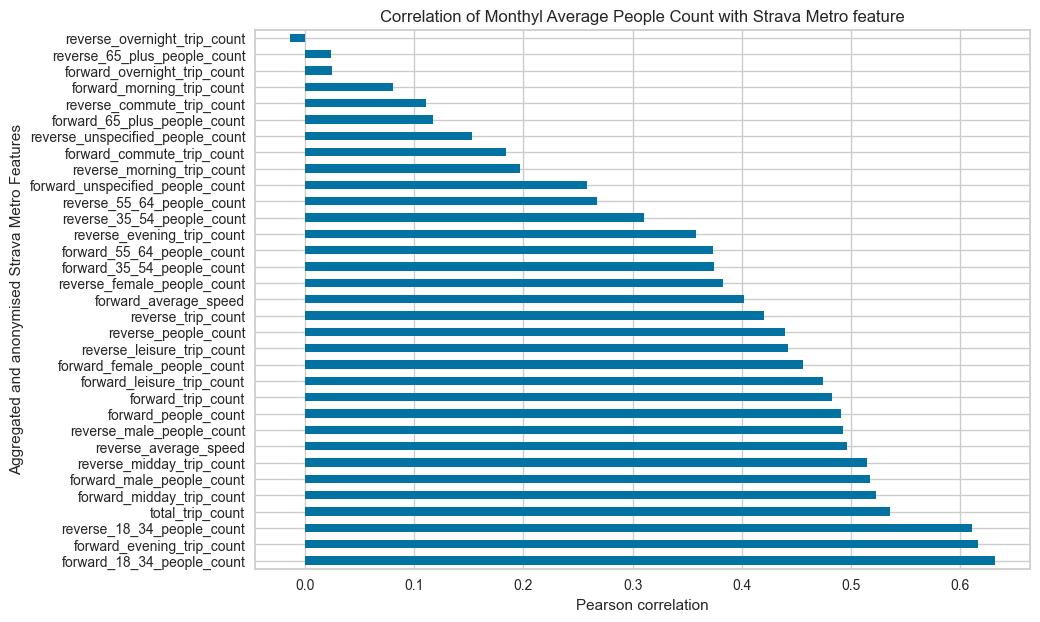

In [38]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=20, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = strava_dat_all_sites.set_index('Date').corr(method="pearson")

# plot the STRAVA metro data with the highest correlation with the Counter data
matrix.sort_values(by='people_counter_data',ascending=False)['people_counter_data'][1:].plot(kind='barh',figsize=(10,7))
plt.xlabel('Pearson correlation')
plt.ylabel('Aggregated and anonymised Strava Metro Features')
plt.title('Correlation of Monthyl Average People Count with Strava Metro feature')

plt.savefig(f"./outputs/MAPC_strava_corr.png", format= 'png', dpi=300, bbox_inches='tight')

# we hand-pick a feature with the highest correlation 
# with the NE counter feature: we choose total_trip_count

#### Univariate Regression Model

<a id='dest_5'></a>

<Axes: ylabel='site'>

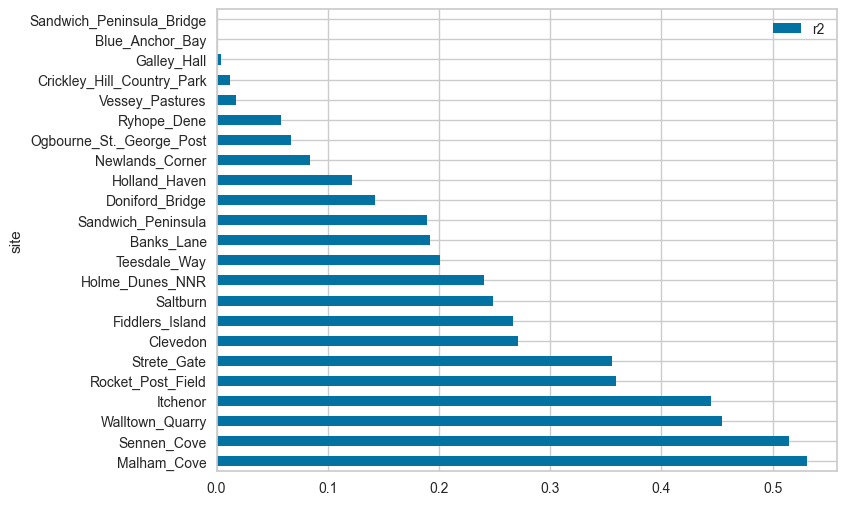

In [32]:
# Natural England: 

df_univ_ne=df_count_ne_strava[['Date','site','people_counter_data',chsen_ftr_strava]].copy()
df_univ_ne=df_univ_ne.set_index('Date').sort_index()

# Univariate regression model between people counter-Strava
df = df_univ_ne
fig = px.scatter(df, x=chsen_ftr_strava, y="people_counter_data",\
                  color="site",trendline="ols")
fig.show()

results = px.get_trendline_results(fig)

# Store univariate regression outputs
site_values=results['site'].values

str_regrn_ne=[]
for sites in site_values:
    df_site=df[df['site']==sites]
    scaler = StandardScaler()
    df_site[["people_counter_data",chsen_ftr_strava]]=scaler.fit_transform(df_site[["people_counter_data",chsen_ftr_strava]])
    lm = pg.linear_regression(df_site[['people_counter_data']],df_site[chsen_ftr_strava])
    lm['site']=sites
    str_regrn_ne.append(lm)
    
str_regrn_ne=pd.concat(str_regrn_ne).reset_index(drop=True)

str_regrn_ne[['r2','site']].drop_duplicates().set_index('site').sort_values(by='r2',ascending=False).\
plot(kind='barh',figsize=(8,6))

<Axes: ylabel='site'>

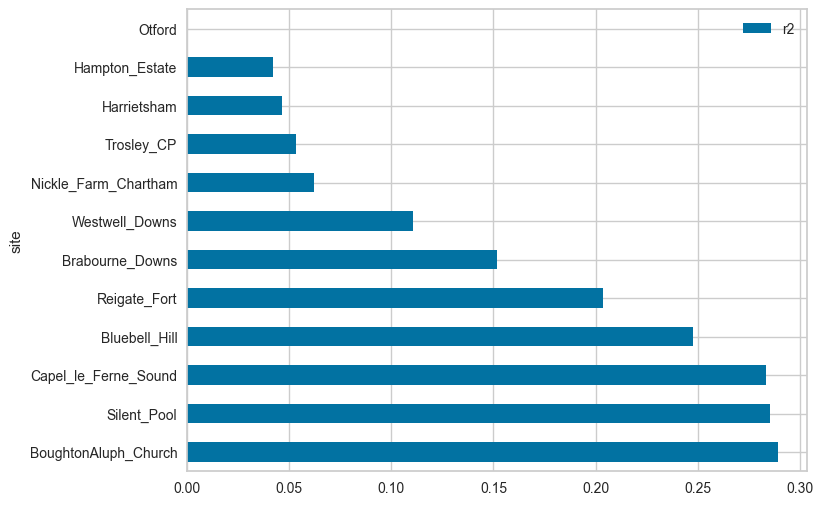

In [33]:
# North Downs Way

df_univ_nd=df_count_nd_strava[['Date','site','people_counter_data',chsen_ftr_strava]].copy()
df_univ_nd=df_univ_nd.set_index('Date').sort_index()

# Univariate regression model between people counter-Strava
df = df_univ_nd
fig = px.scatter(df, x=chsen_ftr_strava, y="people_counter_data",\
                  color="site",trendline="ols")
fig.show()

results = px.get_trendline_results(fig)

# Store univariate regression outputs
site_values=results['site'].values

str_regrn_nd=[]
for sites in site_values:
    df_site=df[df['site']==sites]
    scaler = StandardScaler()
    df_site[["people_counter_data",chsen_ftr_strava]]=scaler.fit_transform(df_site[["people_counter_data",chsen_ftr_strava]])
    lm = pg.linear_regression(df_site[['people_counter_data']],df_site[chsen_ftr_strava])
    lm['site']=sites
    str_regrn_nd.append(lm)
    
str_regrn_nd=pd.concat(str_regrn_nd).reset_index(drop=True)

str_regrn_nd[['r2','site']].drop_duplicates().set_index('site').sort_values(by='r2',ascending=False).\
plot(kind='barh',figsize=(8,6))

<Axes: ylabel='site'>

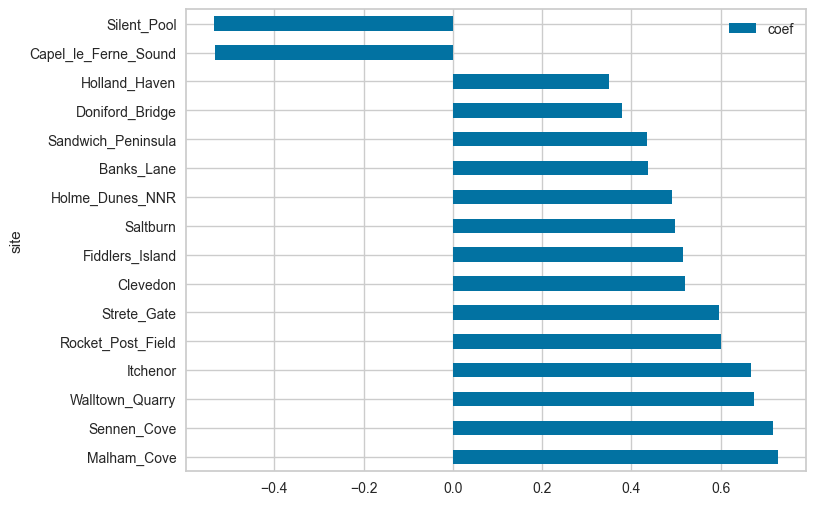

In [34]:
str_regrn_ne_nd=pd.concat([str_regrn_ne,str_regrn_nd])

str_regrn_ne_nd=str_regrn_ne_nd[str_regrn_ne_nd['names'].isin(['people_counter_data'])]

str_regrn_ne_nd=str_regrn_ne_nd[['names','coef','pval','site']]

str_regrn_ne_nd=str_regrn_ne_nd[str_regrn_ne_nd['pval']<0.05]

str_regrn_ne_nd_countr=str_regrn_ne_nd[str_regrn_ne_nd['names']=='people_counter_data']


str_regrn_ne_nd_countr[['coef','site']].drop_duplicates().set_index('site').sort_values(by='coef',ascending=False).\
plot(kind='barh',figsize=(8,6))

In [ ]:
# River and Canal Trust: No counter data available

df_univ_cr=df_count_cr_strava[['Date','site',chsen_ftr_strava]].copy()


df_univ_cr=df_univ_cr.set_index('Date').sort_index()


df_univ_cr=df_univ_cr[['site',chsen_ftr_strava]]

## Merge static and dynamic features

<a id='dest_6'></a>

### 1. Merge OSM data with counter data

In [ ]:
# Merge dynamic features with static (spatial) features: Natural England

df_univ_ne=df_univ_ne.reset_index().merge(df_pois_all_sites,on=['site'],how='inner').\
set_index('Date').sort_index()

df_univ_ne=df_univ_ne.reset_index()

df_univ_ne=df_univ_ne.sort_values(['Date', 'site'], ascending=[True, True])

In [ ]:
# Merge dynamic features with static (spatial) features: North Downs

df_univ_nd=df_univ_nd.reset_index().merge(df_pois_all_sites,on=['site'],how='inner').\
set_index('Date').sort_index()

df_univ_nd=df_univ_nd.reset_index()

df_univ_nd=df_univ_nd.sort_values(['Date', 'site'], ascending=[True, True])

In [ ]:
# Merge dynamic features with static (spatial) features: Canal and River Trust

df_univ_cr=df_univ_cr.reset_index().merge(df_pois_all_sites,on=['site'],how='inner').\
set_index('Date').sort_index()

df_univ_cr=df_univ_cr.reset_index()

df_univ_cr=df_univ_cr.sort_values(['Date', 'site'],ascending=[True, True])

### 2. Merge Weather data with counter data

Filter weather data for people counter sites

https://meteostat.net/en/blog/obtain-weather-data-any-location-python

In [ ]:
weather_df=pd.read_pickle(data_folder+'weather_df.pkl')

weather_df['Date']=weather_df['Date'].astype(str)

In [ ]:
df_univ_ne['Date']=df_univ_ne['Date'].astype(str)

df_univ_ne=df_univ_ne.copy().merge(weather_df,on=['Date','site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_ne.isna().sum(axis=0).sum(),df_univ_ne['site'].unique().shape[0]))

In [ ]:
df_univ_nd['Date']=df_univ_nd['Date'].astype(str)

df_univ_nd=df_univ_nd.copy().merge(weather_df,on=['Date','site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_nd.isna().sum(axis=0).sum(),df_univ_nd['site'].unique().shape[0]))

In [ ]:
df_univ_cr['Date']=df_univ_cr['Date'].astype(str)

df_univ_cr=df_univ_cr.copy().merge(weather_df,on=['Date','site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_cr.isna().sum(axis=0).sum(),df_univ_cr['site'].unique().shape[0]))

### 3. Merge Demographic data with counter data

In [ ]:
df_demg_ne.rename(columns={'counter':'site'},inplace=True)

df_demg_nd.rename(columns={'counter':'site'},inplace=True)

df_demg_cr.rename(columns={'counter':'site'},inplace=True)

In [ ]:
df_univ_ne=df_univ_ne.merge(df_demg_ne,on=['site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_ne.isna().sum(axis=0).sum(),df_univ_ne['site'].unique().shape[0]))

In [ ]:
df_univ_nd=df_univ_nd.merge(df_demg_nd,on=['site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_nd.isna().sum(axis=0).sum(),df_univ_nd['site'].unique().shape[0]))

In [ ]:
df_univ_cr=df_univ_cr.merge(df_demg_cr,on=['site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_cr.isna().sum(axis=0).sum(),df_univ_cr['site'].unique().shape[0]))

### 4. Merge green infrastructure data with counter data



In [ ]:
# Select the required variables

df_grn_inf=pd.read_pickle(data_folder+'green_blue_prow_ftrs.pkl')

df_grn_inf.rename(columns={'counter':'site'},inplace=True)


sel_green_ftrs=['site','accessible_green_space_area','waterside_length_km','PROW_Total_length_km']

df_grn_inf=df_grn_inf[sel_green_ftrs]



df_grn_inf=df_grn_inf.set_index('site')



green_infrastrcur_ftrs=list(df_grn_inf.columns)

df_grn_inf=df_grn_inf.reset_index()

#df_grn_inf=df_grn_inf.merge(area_sites_oa.rename(columns={'counter':'site'}),on=['site'],how='inner')

#df_grn_inf['accessible_green_space_area']=df_grn_inf['accessible_green_space_area'].div(df_grn_inf['area_sq_km'])

#df_grn_inf['waterside_length_km']=df_grn_inf['waterside_length_km'].div(np.sqrt(df_grn_inf['area_sq_km']))

#df_grn_inf['PROW_Total_length_km']=df_grn_inf['PROW_Total_length_km'].div(np.sqrt(df_grn_inf['area_sq_km']))

In [ ]:
# MERGE GREEN INFRASTRUCTURE FEATURES on counter data: Natural England 

df_univ_ne=df_univ_ne.merge(df_grn_inf,on=['site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_ne.isna().sum(axis=0).sum(),df_univ_ne['site'].unique().shape[0]))

In [ ]:
# MERGE GREEN INFRASTRUCTURE FEATURES on counter data: North Downs Way 


df_univ_nd=df_univ_nd.merge(df_grn_inf,on=['site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_nd.isna().sum(axis=0).sum(),df_univ_nd['site'].unique().shape[0]))

In [ ]:
# MERGE GREEN INFRASTRUCTURE FEATURES on counter data: canal and river trust 


df_univ_cr=df_univ_cr.merge(df_grn_inf,on=['site'],how='inner')

print('Number of null values {} and number of unique counter sites is {}'.\
      format(df_univ_cr.isna().sum(axis=0).sum(),df_univ_cr['site'].unique().shape[0]))

### 5. Merge season information with counter data

In [ ]:
# Introduce seasons
        
df_univ_ne['season']=df_univ_ne['Date'].apply(lambda x: x.split('-')[1]).apply(lambda x : get_season(x))


df_univ_nd['season']=df_univ_nd['Date'].apply(lambda x: x.split('-')[1]).apply(lambda x : get_season(x))


df_univ_cr['season']=df_univ_cr['Date'].apply(lambda x: x.split('-')[1]).apply(lambda x : get_season(x))


df_univ_ne=pd.get_dummies(df_univ_ne,columns=['season'])

df_univ_nd=pd.get_dummies(df_univ_nd,columns=['season'])

df_univ_cr=pd.get_dummies(df_univ_cr,columns=['season'])

### 6. Merge land habitat and land type information with counter data

In [ ]:
# Read the data: each site is classified into habitat type and land type class

land_habitat_df=pd.read_pickle(habitat_cluster_file)

del land_habitat_df['geometry']

land_habitat_df.rename(columns={'counter':'site'},inplace=True)

land_habitat_df.rename(columns={'labels':'habitat_type_labels'},inplace=True)



land_cluster_df=pd.read_pickle(land_cluster_file)

del land_cluster_df['geometry']

land_cluster_df.rename(columns={'counter':'site'},inplace=True)

land_cluster_df.rename(columns={'labels':'land_type_labels'},inplace=True)

print(list(land_cluster_df['land_type_labels'].unique()))

print(list(land_habitat_df['habitat_type_labels'].unique()))



df_univ_ne=df_univ_ne.merge(land_cluster_df[['site','land_type_labels']],on=['site'],how='inner')
df_univ_ne=df_univ_ne.merge(land_habitat_df[['site','habitat_type_labels']],on=['site'],how='inner')

df_univ_nd=df_univ_nd.merge(land_cluster_df[['site','land_type_labels']],on=['site'],how='inner')
df_univ_nd=df_univ_nd.merge(land_habitat_df[['site','habitat_type_labels']],on=['site'],how='inner')

df_univ_cr=df_univ_cr.merge(land_cluster_df[['site','land_type_labels']],on=['site'],how='inner')
df_univ_cr=df_univ_cr.merge(land_habitat_df[['site','habitat_type_labels']],on=['site'],how='inner')

### 7. Merge Dog ownership data with counter data

In [ ]:
# read the data
df_dog_ownrshp=pd.read_pickle(dog_ownership)

df_dog_ownrshp.rename(columns={'counter':'site'},inplace=True)

df_univ_ne=df_univ_ne.merge(df_dog_ownrshp,on=['site'],how='left').fillna(0)

df_univ_nd=df_univ_nd.merge(df_dog_ownrshp,on=['site'],how='left').fillna(0)

df_univ_cr=df_univ_cr.merge(df_dog_ownrshp,on=['site'],how='left').fillna(0)

In [ ]:
#demog_ftrs=[x for x in list(all_sites_demographic.select_dtypes(include=[np.number]).columns.values)]

#print(demog_ftrs)

ftrs_to_keep=list(set(df_univ_ne.columns).intersection(df_univ_nd.columns))

ftrs_to_keep=list(set(ftrs_to_keep).intersection(df_univ_cr.columns))

print(sorted(ftrs_to_keep))

In [ ]:
# Get all the data for all the sites
df_sites_ne_nd_cr=pd.concat([df_univ_ne[ftrs_to_keep+[target]],df_univ_nd[ftrs_to_keep+[target]],\
                             df_univ_cr[ftrs_to_keep]],axis=0).reset_index(drop=True)

df_sites_ne_nd_cr.to_pickle(data_folder+'complete_dataset.pkl')

In [ ]:
df_sites_ne_nd_cr.dropna().groupby('Date')['site'].count().plot(style='-o')
plt.ylabel('Number of monitoring sites with training data available')